# Chapter 4: Rising Seas

### Generation of plots based on [the relevant Climate Indicators' report](https://climate.copernicus.eu/climate-indicators/sea-level).

The ocean water in our planet covers over 70% of its surface, making it an ocean world. Not only that, but a large part of the global population resides near the coast, as does a lot of infrastructure and economic assets. Thus, although changes in sea level are a slow process, they can have a substantial impact in our future. 

In this tutorial we will:
1. Search, download, and view data freely available in [Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/home).
2. Use dask (within `xarray`) for chunking data due to memory limitations.
3. Calculate global timeseries and analyse trends.
4. Create timeseries plots as well as gridded plots.

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <!-- <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s/main?labpath=reanalysis-climatology.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th> -->
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ECMWFCode4Earth/sketchbook-earth/blob/main/tutorials/04_sea_level/04_sea_level.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ECMWFCode4Earth/sketchbook-earth/blob/main/tutorials/04_sea_level/04_sea_level.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

### Section 1. Install & import the necessary packages.

The first step for being able to analyse and plot the data is to download and import the necessary libraries for this tutorial. In the GitHub repository you can find the full environment that has all the libraries needed for this and the other tutorials. The environment can be installed in Linux with the simple command: `conda env create -f environment.yml`. This would be the best option if you use this and the rest tutorials on your local computer. If you are using this tutorial in Google Colab most of the required libraries are already preinstalled in the environment and there are only few libraries that should be downloaded.

<div class="alert alert-block alert-warning">
    
<b>NOTE</b>: <br>
After you execute the below cell you might be prompted by Google Colab to "Restart the Runtime". If this happens, please restart the runtime and move on the next cell.
</div>

In [1]:
# download libraries not available in the default Google Colab environment
%pip install cdsapi

# need some extra arguments for intalling cartopy otherwise some features of this library break the script if it is run in Google Colab 
%pip install shapely cartopy --no-binary shapely --no-binary cartopy --force # more info at https://github.com/SciTools/cartopy/issues/1490

Let's now import all the required libraries in our environment. We categorized the libraries based on that they are used for: general libraries, libraries for data analysis, and plotting libraries.

In [1]:
# General libraries
import calendar # date calculations
import zipfile # for unzipping data
import os # operating system interfaces library
import cdsapi # CDS API
from scipy.stats import linregress # linear regression for simple trend calculation

# Libraries for working with multidimensional arrays
import numpy as np # for n-d arrays
import xarray as xr # for n-d arrays (including metadata for all the dimensions)

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.geoaxes

The below is for having a consistent plotting across all tutorials. It **will NOT work in Google Colab** or other cloud services, unless you include the file (available in the Github repository) in the cloud and in the same directory as this notebook, and use the correct path, e.g.
`plt.style.use('copernicus.mplstyle')`.

In [2]:
plt.style.use('../copernicus.mplstyle') # use the predefined matplotlib style for consistent plotting across all tutorials

### Section 2. Download data from CDS.

Let's create a folder were all the data will be stored.

In [3]:
dir_loc = 'data/' # assign folder for storing the downloaded data
os.makedirs(f'{dir_loc}/monthly/', exist_ok=True) # create the folder if not available

Enter CDS API key


We will request data from the Climate Data Store (CDS) programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: `URL` and `KEY` which build together your CDS API key. The string of characters that make up your KEY include your personal User ID and CDS API key. To obtain these, first register or login to the CDS (http://cds.climate.copernicus.eu), then visit https://cds.climate.copernicus.eu/api-how-to and copy the string of characters listed after "key:". Replace the `#########` below with that string.

In [4]:
# CDS key
cds_url = 'https://cds.climate.copernicus.eu/api/v2'
cds_key = '########' # please add your key here the format should be as {uid}:{api-key}

Get Sea level data from [the satellite products that are available at CDS](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-level-global?tab=form).
As you can notice is the page, there is the option to download daily or monthly data. Here we use monthly data for reducing the time and storage requirements. Even with monthly data, it still needs around 15 minutes to get the data from the server, and the zipped file's size is 1Gb.

In [12]:
c = cdsapi.Client(url=cds_url, key=cds_key)

c.retrieve(
    'satellite-sea-level-global',
    {
        'version': 'vDT2021',
        'format': 'zip',
        'variable': 'monthly_mean',
        'year': list(range(1993, 2023)),
        'month': [('0'+str(i))[-2:] for i in list(range(1, 13))], # the months should be given as 2digit (e.g., '01', '12')
    },
    f'{dir_loc}/monthly/sea_level.zip')

2023-06-24 23:28:10,126 INFO Welcome to the CDS
2023-06-24 23:28:10,127 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-sea-level-global
2023-06-24 23:28:10,277 INFO Request is queued
2023-06-24 23:28:11,387 INFO Request is running
2023-06-24 23:32:31,145 INFO Request is completed
2023-06-24 23:32:31,146 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data7/dataset-satellite-sea-level-global-9474a011-e821-4b2d-85f3-1952050467ed.zip to data/sea_level.zip (995M)
2023-06-24 23:46:37,744 INFO Download rate 1.2M/s   


Result(content_length=1043362929,content_type=application/zip,location=https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data7/dataset-satellite-sea-level-global-9474a011-e821-4b2d-85f3-1952050467ed.zip)

The data are downloaded in zip format. Let's unzip them.

In [8]:
with zipfile.ZipFile(f'{dir_loc}/monthly/sea_level.zip','r') as zip_ref:
    zip_ref.extractall(f'{dir_loc}/monthly/') # unzip file

os.remove(f'{dir_loc}/monthly/sea_level.zip') # delete original zip file

Read all the unzipped files (each file is for one year-month). This takes a little time ...

In [4]:
sea_level = xr.open_mfdataset(f'{dir_loc}/monthly/*.nc') # wildcard to read all files (one per year-month) at once & concat in single dataset
sea_level

<xarray.Dataset>
Dimensions:           (time: 355, nv: 2, latitude: 720, longitude: 1440)
Coordinates:
  * time              (time) datetime64[ns] 1993-01-15 1993-02-15 ... 2022-07-15
  * latitude          (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude         (longitude) float32 0.125 0.375 0.625 ... 359.6 359.9
  * nv                (nv) int32 0 1
Data variables:
    crs               (time) int32 -2147483647 -2147483647 ... -2147483647
    climatology_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds          (time, latitude, nv) float32 dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds          (time, longitude, nv) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    sla               (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    eke               (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/43)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Monthly Mean of Sea Level Anomalies refe...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         Delayed Time Level-4 monthly means of Se...
    time_coverage_duration:          P1M
    time_coverage_end:               1993-01-31T00:00:00Z
    time_coverage_resolution:        P1M
    time_coverage_start:             1993-01-01T00:00:00Z
    title:                           DT merged two-satellite Global Ocean L4 ...

Note that the data are read as chunks with dask, meaning that the data are not loaded in the memory. This helps when we process a very large amount of data that can't be loaded at once in the memory. On the other hand, it makes calculations considerably slower.\
Also note that longitude data are 0~360 degrees, so let's convert to -180 ~ 180, which is more common.\
Finally, we will only use the `sla` variable (sea level anomalies) from the dataset, as this is the variable of interest.

In [5]:
# change longitudes to -180 | 180
sla = sea_level['sla']
sla = sla.assign_coords(longitude=(((sla.longitude + 180) % 360) - 180)).sortby('longitude')
sla

<xarray.DataArray 'sla' (time: 355, latitude: 720, longitude: 1440)>
dask.array<getitem, shape=(355, 720, 1440), dtype=float64, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1993-01-15 1993-02-15 ... 2022-07-15
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Attributes:
    cell_methods:   time: mean within years
    grid_mapping:   crs
    long_name:      Averaged Sea Level Anomalies 1993/01
    standard_name:  sea_surface_height_above_sea_level
    units:          m

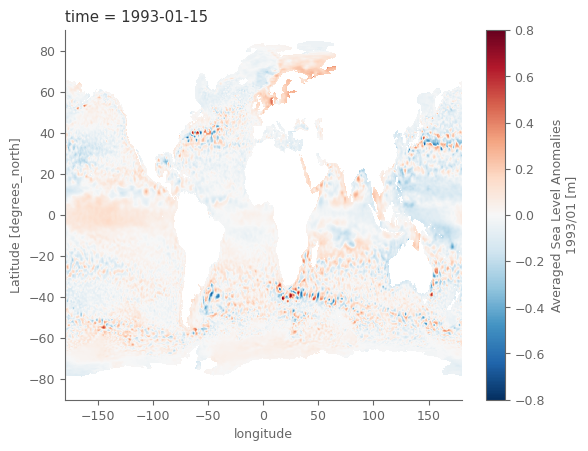

In [6]:
# "quick and dirty" plot of the data
sla.isel(time=0).plot() 

### Section 3. Data analysis and plotting

#### Global average

The data are projected in lat/lon system. This system does not have equal areas for all grid cells, but as we move closer to the poles, the areas of the cells are reducing. These differences can be accounted when weighting the cells with the cosine of their latitude.

In [7]:
def area_weighted_spatial_average(data):
    """Calculate area-weighted spatial average of data
    
    Parameters
    ----------
    data : xarray.DataArray
        DataArray with lat and lon coordinates

    Returns
    -------
    xarray.DataArray
        Area-weighted spatial average
    
    """
    weights = np.cos(np.deg2rad(data.latitude)).clip(0, 1) # weights
    return data.weighted(weights).mean(['latitude', 'longitude'])

Calculate global average sea level anomaly for the monthly timeseries. This will take a while...

In [8]:
global_average_sla = area_weighted_spatial_average(sla).compute() # use compute so that the data are now loaded into memory (no more dask)

#### Annual trend calculation

Let's calculate the annual trend for the data. For this step, first we will resample the monthly data to annual so that we don't have influence of possible variations of higher frequency, as for example the seasonality.

Resample the monthly data to annual by weighting the months considering the total number of days per month.

In [9]:
def annual_weigthed_mean(data):
    """Calculate weighted annual mean from monthly data, when considering the exact number of days for each month for getting the weights
    
    Parameters
    ----------
    data : xarray.DataArray
        DataArray with time coordinates in monthly resolution

    Returns
    -------
    xarray.DataArray
        Weighted annual mean
    
    """

    annual_mean = []
    for i, j in data.groupby('time.year'): # group data per year
        days_month = [calendar.monthrange(yr, mn)[1] for yr, mn in zip([i]*len(j.time), j.time.dt.month.values)] # get number of days per month
        weights_temporal = j.time.astype(int)*0+days_month # get temporal weights as xarray dataarray
        # weights should be changed to NaN for the cells that have NaN in the relevant month
        weights_temporal = weights_temporal.where(j.notnull()).fillna(0) # mask weights for all instances with no data, and get weights to 0

        annual_mean.append( j.weighted(weights_temporal).mean('time').assign_coords(year=i) ) # get the weighted mean

    annual_mean = xr.concat(annual_mean, dim='year') # get final dataarray with the annual growth rates

    return annual_mean

Calculate global average sea level anomaly for the annual data.

In [14]:
global_average_annual_sla = annual_weigthed_mean(global_average_sla)
global_average_annual_sla.to_dataset() # we use 'dataset' object instead of 'dataarray' so that the information are visually nicer

<xarray.Dataset>
Dimensions:  (year: 30)
Coordinates:
  * year     (year) int64 1993 1994 1995 1996 1997 ... 2018 2019 2020 2021 2022
Data variables:
    sla      (year) float64 0.0002212 0.00159 0.003856 ... 0.08853 0.08751

Use `linregress` from the `scipy` library and `appply_func` from the `xarray` library for calculating the linear trend and the standard error of the estimated slope. More information are available in the documentations of [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) and [xarray](https://docs.xarray.dev/en/stable/generated/xarray.apply_ufunc.html).

In [113]:
def linregress_1d(data, years):
    
    """
    The function returns an array with 5 elements. The 1st and 2nd element are the slope and intersect of the regression, and the 5th value 
    is the standard error of the estimated slope.
    """

    return np.array(linregress(years, data)[:])

In [114]:
global_trend = xr.apply_ufunc(linregress_1d, 
                              global_average_annual_sla*1e3, global_average_annual_sla.year.values,
                              input_core_dims=[["year"], ['t']], output_core_dims=['a'], vectorize=True)

Caclulate fitted values for the linear trend.

In [149]:
time_float = global_average_sla.time.dt.year + global_average_sla.time.dt.dayofyear/365 # get monthly time as float
linear_fit = global_trend[0]*time_float + global_trend[1] # use the time_float and the coefficients of global_trend to fit the data

In [137]:
# monthly = global_average_sla.assign_coords({'time': global_average_sla.time.dt.year + global_average_sla.time.dt.dayofyear/365})

# global_trend_from_monthly = xr.apply_ufunc(linregress_1d, 
#                                            monthly*1e3, monthly.time.values,
#                                            input_core_dims=[["time"], ['t']], output_core_dims=['a'], vectorize=True)
# global_trend_from_monthly[4]

# linear_trend_monthly = (monthly*1e3).polyfit(dim='time', deg=1)['polyfit_coefficients']
# linear_trend_monthly

# linear_fit = linear_trend_monthly[0]*monthly.time + linear_trend_monthly[1]
# linear_fit = linear_fit.assign_coords({'time': global_average_sla.time.values}) # back to datetime object for time coordinate
# linear_fit

#### Plotting the monthly timeseries

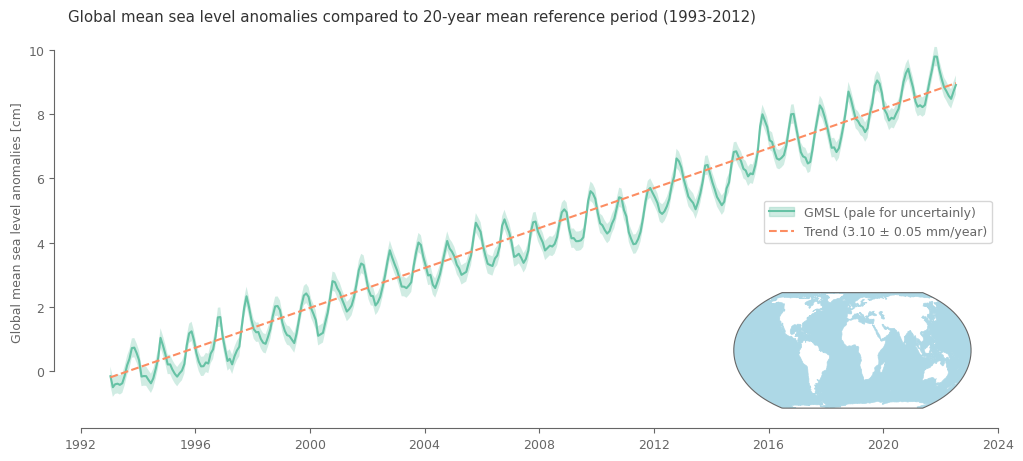

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5)) # create the figure and define subplots and figure size
p1 = (100*global_average_sla).plot(ax=ax) # plot in cm rather than m that is the unit of the data
ax.fill_between(global_average_sla.time.values, 100*global_average_sla-.3, 100*global_average_sla+.3, alpha=.3)
p2 = ax.fill(np.NaN, np.NaN, alpha=0.3, color=p1[0].get_color()) # auxiliary plot with no data that is needed for the legend
p3 = (.1*linear_fit).plot(ax=ax, linestyle='--') # plot the trend data (need to convert to cm from mm)
ax.legend([(p2[0], p1[0]), p3[0]], 
          ['GMSL (pale for uncertainly)', f'Trend ({global_trend[0]:0.2f} \u00B1 {global_trend[4]:0.2f} mm/year)'], loc=5) # add legend

sns.despine(ax=ax, trim=True, offset=10) # trimming the y and x axis to be visible only from the first till the last tick
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # formatting is needed cause the above line breaks the time xticklabels

ax.set_xlabel('') # remove the title from the horizontal axis
ax.set_ylabel('Global mean sea level anomalies [cm]') # set title in vertical axis
ax.set_title('Global mean sea level anomalies compared to 20-year mean reference period (1993-2012)') # set title for the subplot

# add a small map showing the spatial domain that was used to derive the timeseries. This will be done with the help of inset_axes
axins = inset_axes(ax, # define the parent subplot
                   width="30%", height="30%", loc="lower right", # give dimensions and location of the nested subplot
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, # define subplot class so that geospatial data can be used
                   axes_kwargs=dict(projection=ccrs.EqualEarth()) # assign a projection in the nested subplot
                   )
axins.add_feature(cfeature.OCEAN, color='lightblue', lw=.5) # add the oceans as polygons from the cartopy library

plt.show()

#### Variations in space

We noticed that there is an increasing trend in the global average sea level rise. Let's now calculate this trend for each grid point using the same simple linear model.\
First of all we need to rechunk the data so that the time dimension is not segmented, because the trend calculation needs all time steps for each location.

In [152]:
sla = sla.chunk(chunks={'time': -1, 'latitude': 72, 'longitude': 144}) # rechunk so time is not segmented (needed for trends)
sla

<xarray.DataArray 'sla' (time: 355, latitude: 720, longitude: 1440)>
dask.array<rechunk-merge, shape=(355, 720, 1440), dtype=float64, chunksize=(355, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1993-01-15 1993-02-15 ... 2022-07-15
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Attributes:
    cell_methods:   time: mean within years
    grid_mapping:   crs
    long_name:      Averaged Sea Level Anomalies 1993/01
    standard_name:  sea_surface_height_above_sea_level
    units:          m

Calculate mean annual anomalies of sea level. This will take a while...

In [154]:
average_annual_sla = annual_weigthed_mean(sla).compute()
average_annual_sla.to_dataset() # remember that we use 'dataset' object instead of 'dataarray' so that the information are visually nicer 

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, year: 30)
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * year       (year) int64 1993 1994 1995 1996 1997 ... 2019 2020 2021 2022
Data variables:
    sla        (year, latitude, longitude) float64 nan nan nan ... nan nan nan

Calculate the annual trend, again with the help of `apply_func`.

In [156]:
gridded_trend = xr.apply_ufunc(linregress_1d, 
                               average_annual_sla*1e3, average_annual_sla.year.values,
                               input_core_dims=[["year"], ['t']], output_core_dims=['a'], vectorize=True)
gridded_trend.to_dataset() # remember that we use 'dataset' object instead of 'dataarray' so that the information are visually nicer 

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, a: 5)
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Dimensions without coordinates: a
Data variables:
    sla        (latitude, longitude, a) float64 nan nan nan nan ... nan nan nan

In [162]:
trends_slope = gridded_trend.isel(a=0) # get the slice with the slope data (remember it is the 1st value)

#### Plotting gridded data

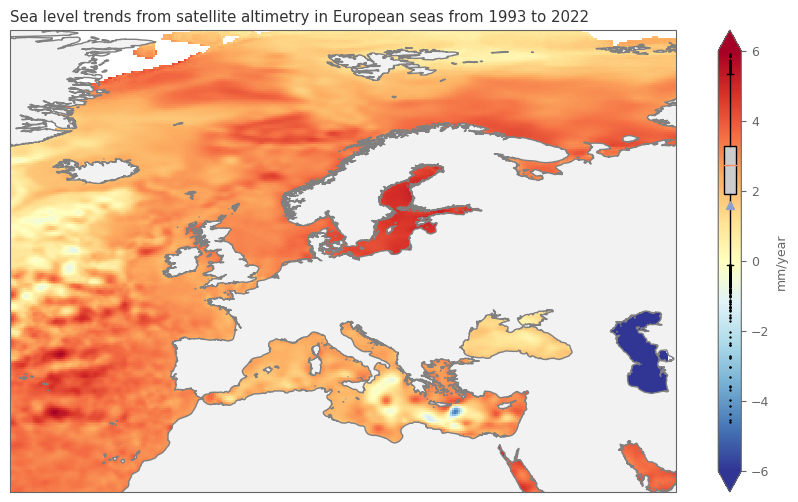

In [347]:
fig, ax = plt.subplots(1, 1, figsize=(11, 6), subplot_kw={'projection': ccrs.PlateCarree()})
slope_data = trends_slope.sel(latitude=slice(24, 83), longitude=slice(-30, 55))
# slope_plot = trends_slope.where(gridded_trend.isel(a=3)<0.05) # if only significant trends are kept for plotting
# slope_plot = slope_plot.plot(vmin=-6, vmax=6, cmap='RdYlBu_r', extend='both', cbar_kwargs={'label': "mm/year"}, ax=ax)
slope_plot = slope_data.plot(vmin=-6, vmax=6, cmap='RdYlBu_r', add_colorbar=False, robust=True, ax=ax, transform=ccrs.PlateCarree())
# (slope_data<0).plot()
ax.add_feature(cfeature.NaturalEarthFeature(category='physical', scale='10m', edgecolor='0.5', facecolor='.95', name='land')) # add land mask
min_year, max_year = average_annual_sla.year.values[::len(average_annual_sla.year)-1] # get min and max year of data
ax.set_title(f'Sea level trends from satellite altimetry in European seas from {min_year} to {max_year}')

# add colorbar and plot inside it the boxplot of the trends, for visualizing also the statistics
cbar_ax = fig.colorbar(slope_plot, extend='both', label='mm/year') # add colorbar 
cbar_ax.ax.boxplot(x=slope_data.to_dataframe()['sla'].dropna().values, # boxplot of the trend data
                   positions=[.5], # define position at 0.5 so that they are plotted in the middle of colorbar (0-1), because default is 1
                   widths=0.5, # slightly inceease the width of the boxplot]
                   patch_artist=True, # allow changes on the boxplot
                   boxprops=dict(facecolor='.8'), # change color of boxplot (so that median is more visible)
                   showmeans=True, # also show the mean as a triangle
                   flierprops={'marker': '+', 'markersize': 2} # change style and size of outliers
                   )
cbar_ax.ax.set_xticks([]) # remove the xticks

plt.show()

The above plot shows that for the majority of the European seas there is an increasing trend in the sea level, ranging between 2-3 mm/year, whereas some regions experience an increase over 5 mm/year. Only in confined parts of east Mediterraean, in particular south of Creta island and in the Ionian sea, between mainland Greece and Italy, there is a decrease of the sea level.\
Please note that Caspian Sea has a substantial descrease, but this is not related to the sea level, as it is a closed system (lake) that is not affected by changes in the sea ice in the poles, etc.

### Appendix: Calculations with daily data

This requires 30Gb of data and a considerable amount of time for downloading the data and performing the calculations...

In [5]:
os.makedirs(f'{dir_loc}/daily/', exist_ok=True) # create the folder if not available

In [6]:
c = cdsapi.Client(url=cds_url, key=cds_key)

# we need to loop every year, otherwise the data are too many to be donwloaded from CDS
# for i_year in range(1993, 2023):
for i_year in range(1994, 1996): # use only 2 years just for speeding up the process and reducing the time (it still needs some hours)
    c.retrieve(
        'satellite-sea-level-global',
        {
            'version': 'vDT2021',
            'format': 'zip',
            'variable': 'daily',
            'year': i_year,
            'month': [('0'+str(i))[-2:] for i in list(range(1, 13))], # the months should be given as 2digit (e.g., '01', '12'),
            'day': [('0'+str(i))[-2:] for i in list(range(1, 32))], # the months should be given as 2digit (e.g., '01', '31'),
        },
        f'{dir_loc}/daily/{i_year}_sea_level.zip')

    # unzip and remove the original file
    with zipfile.ZipFile(f'{dir_loc}/daily/{i_year}_sea_level.zip','r') as zip_ref:
        zip_ref.extractall(f'{dir_loc}/daily/') # unzip file

    os.remove(f'{dir_loc}/daily/{i_year}_sea_level.zip') # delete the original zip file

2023-07-03 01:54:19,412 INFO Welcome to the CDS
2023-07-03 01:54:19,413 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-sea-level-global
2023-07-03 01:54:19,742 INFO Request is queued
2023-07-03 01:54:20,888 INFO Request is running
2023-07-03 02:04:41,424 INFO Request is completed
2023-07-03 02:04:41,425 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data8/dataset-satellite-sea-level-global-0a43fbdd-15e9-46a1-a8d8-7f7dd2e1b0f3.zip to data//daily/1994_sea_level.zip (3.3G)
2023-07-03 02:52:08,662 INFO Download rate 1.2M/s    
2023-07-03 02:53:26,276 INFO Welcome to the CDS
2023-07-03 02:53:26,278 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-sea-level-global
2023-07-03 02:53:26,500 INFO Request is queued
2023-07-03 02:53:27,630 INFO Request is running
2023-07-03 03:03:48,846 INFO Request is completed
2023-07-03 03:03:48,848 INFO Downloading https://download-0001-clone.